# Denoising autoencoders (DAE's) - Autoencoder Convolucional para eliminar el ruido de imagenes(mejorar la calidad).

by José Manuel Pedro Méndez to Introducción a Redes Neuronales (Temas Selectos de Física Computacional III 2024-1)

En este proyecto, exploraremos la aplicación de un Denoising Autoencoder (DAE) para eliminar el ruido de imágenes utilizando el conjunto de datos MNIST, un autoencoder es una topología(arquitectura) de red neuronal que intenta reconstruir sus propias entradas mientras busca una representación compacta de la información dada y es entrenada copiando su entrada a la salida, estos pueden verse como un caso especial de FFN(Feed Forward Networks), para así poder hacer uso de funciones no lineales, intercalándolas entre las capas lineales con el fin de consiguir una transformación generalizada no lineal más potente.

La capacidad de nuestro modelo está determinada por sus parámetros entrenables, pero para potenciar la capacidad de un autoencoder y forzar la extracción de características útiles, implementaremos una estrategia específica: agregaremos ruido gaussiano a las imágenes de entrada. Así, los datos de entrenamiento consistirán en versiones ruidosas de las imágenes originales, y el autoencoder buscará aprender a recuperar las imágenes originales sin ruido.

El proceso de aprendizaje de estas representaciones(representaciones latentes), implica que el autoencoder intenta copiar su entrada en su salida. Esto se traduce en que la entrada y la salida suelen ser prácticamente idénticas. Sin embargo, para forzar la extracción de patrones relevantes, podemos imponer restricciones, como limitar el tamaño de la representación latente o añadir ruido a las entradas.

Existen diferentes formas de restringir a un autoencoder con el objetivo de forzarlo a extraer patrones relevantes de los datos. Entre las más conocidas se encuentran: el limitar el tamaño de la representación latente(que dicha representación tenga una dimensión menor que la dimensión de
los datos de entrada), el añadir ruido a las entradas y entrenar el autoencoder para recuperar las entradas originales libres de ruido. Esta última será una de las estrategías que seguiremos.

* Independientemente de las restricciones impuestas, todos los autoencoders comparten una arquitectura común, compuesta por dos partes fundamentales:
  1. **Encoder**: encargado de transformar la entrada x, en la representación latente, representada por el vector z = f (x).
  2. **Decoder**: cuyo trabajo consiste en la recuperación de los datos originales a partir de dicha representación latente, $x̅$ = g(z)

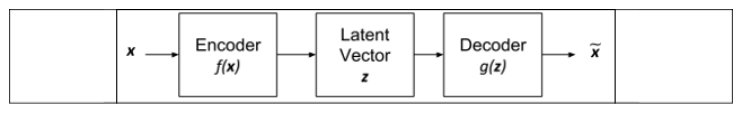

Diagrama de bloques de un autoencoder [3].

- El encoder encuentran una representación de menor espacio en memoria
a partir de los datos originales y el decoder reconstruyen los datos originales a partir de esa representación de menor espacio(*Laten Vector: z*)

En este proyecto exploraremos cómo podemos mejorar la capacidad de un modelo para eliminar ruido en imágenes.

## Librerías ocupadas.

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

In [ ]:
# Importar librerías
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dropout
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras import layers, losses
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt

## Preparación del Dataset.

Descarguemos MNIST ocupando las funciones de TensorFlow, uno de los conjuntos de datos utilizados en clase, además de que en el campo del aprendizaje automático y la visión por computadora es muy ocupado. Consiste en un conjunto de 70,000 imágenes de dígitos escritos a mano(del 0 al 9), cada una de 28x28 píxeles en escala de grises. Sin embargo nosotros ocupamos 60,000 imágenes con ruido para entrenar nuestro modelo y 10,000 para probar que tan bueno es nuestro modelo.  Dado que este es un problema de aprendizaje no supervisado, no le prestaremos atención a las etiquetas, sino únicamente a los ejemplos o instancias de entrenamiento.

In [ ]:
# Cargar el conjunto de datos MNIST
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Podemos consultar una imagen de nuestro dataset, dado un índice.

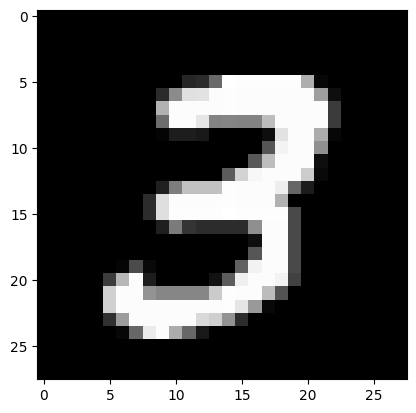

In [ ]:
index = 7
digit = x_train[index]
digit_pixels = digit.reshape(28, 28)
plt.imshow(digit_pixels, cmap='gray')
plt.show()

### Prepocesamiento

Ajustamos el tamaño y normalizamos nuestras imagenes con valores entre 0 y 1. (Aunque creo que este conjunto de datos ya viene normalizado).

In [ ]:
image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_train.shape)

(60000, 28, 28, 1)


A nuestro dataset le agregamos ruido *random* y normalizamos lo que pueda salirse del intervalo [0,1] al agregar ruido.

Se agrega ruido durante el entrenamiento para enseñarle al autoencoder a ser robusto y capaz de recuperar información importante a pesar de la presencia de distracciones o perturbaciones en los datos de entrada. Con el fin de prevenir el sobreajuste y a mejorar la capacidad del modelo para generalizar a datos ruidosos del mundo real.

In [ ]:
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Mostramos 10 de nuestras imagenes tras agregarle el ruido.

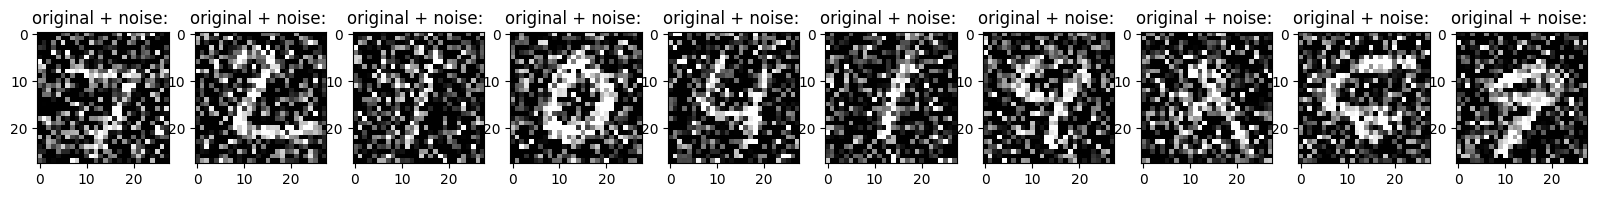

In [ ]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise: ")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

## Definición de un Convuncional Autoencoder

La clase Denoise hereda de tf.keras.Model, y tiene métodos *__init__* y *call* que contienen la lógica de construcción del autoencoder. Las capas del codificador y del decodificador se han integrado en los atributos self.encoder y self.decoder respectivamente. Estos representarán la arquitectura de nuestro Autocodificador, también se ha incluido la creación del modelo completo (autoencoder) dentro de la clase.

- Arquitectura Detallada:
  - Codificador:
    - Dos capas de convolución (Conv2D) con activación ReLU para reducir la dimensionalidad. Junto con un Capa de dropout para regularización en el decodificador, pero solo puse uno porque no quería perder mucho más información
    - Una capa plana (Flatten) como una capa de aplanado que convierte la salida de las capas de convolución en un vector unidimensional, generardo así el vector latente.
    - Una capa densa (Dense)  que proyecta el vector aplanado en el espacio latente, que representa la versión comprimida de la entrada original. Con latent_dim = 16, probe con uno más grande pero no me sirvio de mucho.

  - Decodificador:
    - Una capa densa que toma el vector latente y lo expande para coincidir con la forma antes de la capa plana en el codificador.
    - Seguida de un Reshape para que la salida de la capa densa cambie de modo que tengamos la forma (bidimensional) requerida por las 2 capas deconvolucionales(también conocidas como transpuestas).
    - Dos capas de convolución transpuesta (Conv2DTranspose) con activación ReLU para reconstruir la imagen original, estas aprenden a reconocer patrones locales en la entrada,
    - por último tenemos otra capa deconvolucionale de salida que utiliza una función de activación sigmoide con 1 neurona. para producir valores en el rango [0,1] que representan los píxeles de la imagen reconstruida. La capa de salida utiliza una función de activación sigmoide para producir valores en el rango [0, 1].

In [ ]:
# Definir la clase del modelo autoencoder Denoise
class Denoise(Model):

  def __init__(self):
    super(Denoise, self).__init__()
    # Parámetros de la red
    input_shape = (image_size, image_size, 1)             # Tamaño de las imágenes (28x28,1)
    batch_size = 32
    kernel_size = 4
    latent_dim = 16

    inputs = Input(shape=input_shape, name='Input_encoder')# Construir el modelo del codificador
    x = inputs
    # Capa de convolución 2D 1
    x = Conv2D(filters=32, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
    x = Dropout(0.20)(x)                                  # Capa de dropout para regularización
    # Capa de convolución 2D 2
    x = Conv2D(filters=64, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
    shape = K.int_shape(x)                                # Obtener la forma actual para la capa de aplanado

    x = Flatten()(x)                                      # aplanamos la salida para generar el latent vector
    latent = Dense(latent_dim, name='Latent_vector')(x)   # Capa densa para representar el vector latente
    self.encoder = Model(inputs, latent, name='encoder')  # Instanciar el modelo del codificador

    # Construir el modelo del decodificador
    latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
    x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)    # Capa densa para expandir el vector latente
    # Obtenemos la forma adecuada para que nuestras capas que siguen puedan trabajar
    x = Reshape((shape[1], shape[2], shape[3]))(x)

    # 2 capas Conv2DTranspose(64)-Conv2DTranspose(32) que hacen lo contrario a las que ocupamos en el encoder
    x = Conv2DTranspose(filters=64, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
    x = Conv2DTranspose(filters=32, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
    # Capa de salida para reconstruir la imagen original
    outputs = Conv2DTranspose(filters=1, kernel_size=kernel_size,
                              padding='same', activation='sigmoid', name='decoder_output')(x)
    self.decoder = Model(latent_inputs, outputs, name='decoder') # Instanciamos el modelo del decodificador

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise() # creamos una instancia de Denoise para usar el autoencoder

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Definir el callback ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Compilar el modelo con el optimizador y el learning rate inicial
initial_learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError())

- Las funciones de activación son el secreto que hace que las redes neuronales sean capaces de resolver problemas complejos.
  1. ReLU: Nos introduce no linealidad en el modelo, lo que es un poco necesario ya que le permite al autoencoder aprender patrones y características no lineales en los datos, como las relaciones entre los píxeles de una imagen no suelen ser lineales, ocupamos está porque nos ayuda a capturar estas relaciones no lineales mucho mejor que funciones lineales.
    - Además proporciona una respuesta no saturada para activaciones positivas y es eficiente en terminos computacionales.
    - Además creo que contribuye a que el autoencoder aprenda representaciones más ricas y no lineales de las imágenes.
  2. Sigmoid: para producir valores en el rango [0,1] que representan los píxeles de la imagen reconstruida.

En todo ocupamos _padding='same'_ para mantener el tamaño de la entrada.


Para compilar ocupamos el optimizador Adam  para ajustar los pesos del modelo durante el entrenamiento y Means Square Error como función de perdida, es decir como una medida de cuán bien el autoencoder está reconstruyendo las imágenes.

En esta parte integramos la callback [ReduceLROnPlateau](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) de Keras, para ajustar automáticamente el learning rate cuando nuestra métrica _val_loss_ deje de disminuir(mejorar), si la pérdida de validación no mejora después de 3 épocas (patience=3), el learning rate se reducirá a factor=0.2 veces su valor actual, mientras que min_lr=0.0001 establece el límite inferior para el learning rate.

### Entrenar el Autocodificador.

Los dos primeros argumentos de la función corresponden a los datos de entrada con ruido y los datos de de salida respectivamente. Entrenamos el modelo con imágenes ruidosas (x_train_noisy y x_test_noisy) y las imágenes limpias correspondientes (x_train y x_test) durante 11 épocas. (reducimos a 9 para evitar sobreentreno).

Habíamos ocupado batch=64 y un dropoout del .25 para evitar el sobre entreno pero solo llegamos teníamos prácticamente un 0.0144 desde la quinta epoca y solo bajo un poco hasta la 7, llegando a 0.0140. Con kernel size = 4 y dropout del 20 hemos mejorado nuestro modelo y llegamos:  loss: 0.0133 - val_loss: 0.0135  pero en la epoca 5 tenemos un aumento de:

Epoch 4/9
1875/1875 [==============================] - 172s 92ms/step - loss: 0.0145 - val_loss: 0.0139 - lr: 0.0010

Epoch 5/9
1875/1875 [==============================] - 182s 97ms/step - loss: 0.0141 - val_loss: 0.0140 - lr: 0.0010

Aumentando el latent_dim=20, batch_size = 64 y kernel_size = 4 con 6 epocas logramos, y ocupando un initial_learning_rate = 0.01 un poco más grande definitivamente, a comparación del 0.001 que habíamos ocupado previamente obtuvimos un peor desempeño desde las primeras 3 épocas.

Por lo que al final obtuvimos el mejor resultado tras 8 epocas con un batch_size = 32 y kernel_size = 4 pero quedandonos con latent_dim = 16.

In [ ]:
history = autoencoder.fit(x_train_noisy, x_train,
                epochs=8, shuffle=True,
                validation_data=(x_test_noisy, x_test),
                 callbacks=[reduce_lr_callback])

Epoch 1/8
1875/1875 [==============================] - 132s 70ms/step - loss: 0.0307 - val_loss: 0.0166 - lr: 0.0010
Epoch 2/8
1875/1875 [==============================] - 129s 69ms/step - loss: 0.0162 - val_loss: 0.0149 - lr: 0.0010
Epoch 3/8
1875/1875 [==============================] - 128s 68ms/step - loss: 0.0150 - val_loss: 0.0142 - lr: 0.0010
Epoch 4/8
1875/1875 [==============================] - 126s 67ms/step - loss: 0.0144 - val_loss: 0.0140 - lr: 0.0010
Epoch 5/8
1875/1875 [==============================] - 127s 68ms/step - loss: 0.0140 - val_loss: 0.0138 - lr: 0.0010
Epoch 6/8
1875/1875 [==============================] - 130s 69ms/step - loss: 0.0137 - val_loss: 0.0137 - lr: 0.0010
Epoch 7/8
1875/1875 [==============================] - 128s 68ms/step - loss: 0.0135 - val_loss: 0.0135 - lr: 0.0010
Epoch 8/8
1875/1875 [==============================] - 128s 68ms/step - loss: 0.0133 - val_loss: 0.0133 - lr: 0.0010


### Sobre nuestra arquitectura:

La estructura del autoencoder (codificador y decodificador) está diseñada para aprender representaciones compactas de las imágenes y reconstruir imágenes limpias a partir de versiones ruidosas, por eso la arquitectura convolucional, ya que está se utiliza para aprovechar la información espacial de las imágenes.

Las capas convolucionales son efectivas para el procesamiento de imágenes(son efectivas para extraer características espaciales en las imágenes), en el codificador ocupamos Conv2D para realizar convoluciones en las imágenes de entrada. Cada filtro en estas capas aprende a detectar patrones locales en la imagen. Usamos strides=2 para la reducción de dimensionalidad, esto ayuda a disminuir el tamaño de la representación espacial, permitiendo que el modelo capture características importantes de manera más eficiente, la información más importante, después de la primera capa de convolucionales tenemos una capa de dropout para regularización en el decodificador, pero solo puse uno porque no quería perder mucho más información.

Las capas densas son utilizadas para la representación compacta, por eso utilizamos este tipo de capas. Después de las capas de convolución en el codificador utilizamos Flatten para convertir la salida en un vector plano. Y al final tenemos una capa densa (Dense) para generar la representación latente del autoencoder, porque está ayuda a reducir aún más la dimensionalidad y extraer características más abstractas.

En el decodificador iniciamos con una capa densa porque necesitamos expandir el vector latente a un tamaño que coincida con la última capa de convolución transpuesta del codificador. Después tenemos un Reshape para remodelar la salida de la capa densa en una forma que pueda ser procesada por las capas de convolución transpuesta, esto es necesario porque necesitamos establecer una conexión entre las capas densas y convolucionales del decodificador.

En el decodificador ocupamos Conv2DTranspose para realizar la transposición de la convolución (deconvolución). Esta capa hace todo lo contrario a la anterior, está ayuda a aumentar la dimensionalidad de la representación espacial, genera una salida que tiene una resolución espacial más alta que la entrada al decodificador, la ocupamos para reconstruir la imagen a partir de la representación latente(la información más relevante previamente extraída).

La dimensionalidad del vector latente (latent_dim) es un hiperparámetro que controla la cantidad de información comprimida en la representación latente del autoencoder, en nuestro caso, nos quedamos con 16.

Para incrementar esta expresividad y conseguir que las redes neuronales no sean funciones lineales se intercalan las capas lineales con funciones no lineales, llamadas funciones de activación. En nuestro caso ocupamos relu en el entrenamiento ya que esta nos permite que no todas las neuronas se activan a la vez, en cambio solo una fracción de ellas se activa, además de que durante el aprendizaje, a veces los valores de peso y sesgo no se actualicen.

Podemos ver en las 9(intente con 10 y más de 11 pero decidí quedarme con 9 porque a partir de 10 prácticamente el modelo no mejoraba) épocas de entrenamiento que muestras indican cómo la pérdida en el conjunto de entrenamiento y el conjunto de validación evoluciona a medida que el modelo aprende durante el entrenamiento.

Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [ ]:
autoencoder.encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_encoder (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 32)        544       
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 64)          32832     
                                                                 
 flatten_1 (Flatten)         (None, 3136)              0         
                                                                 
 Latent_vector (Dense)       (None, 16)                50192     
                                                                 
Total params: 83568 (326.44 KB)
Trainable params: 83568 (32

The decoder upsamples the images back from 7x7 to 28x28.

In [ ]:
autoencoder.decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 16)]              0         
                                                                 
 dense_1 (Dense)             (None, 3136)              53312     
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 14, 14, 64)        65600     
 Transpose)                                                      
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 28, 28, 32)        32800     
 Transpose)                                                      
                                                                 
 decoder_output (Conv2DTran  (None, 28, 28, 1)         513 

Plotting both the noisy images and the denoised images produced by the autoencoder.

In [ ]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

Aplicamos el Autocodificador ya entrenado al conjunto de imágenes del grupo de validación

In [ ]:
# predict the autoencoder output from corrupted test images
x_decoded = autoencoder.predict(x_test_noisy)

313/313 [==============================] - 6s 18ms/step


## Visualización de Imágenes como métrica visual para ver el funcionamiento de nuestro autoencoder

Visualizando las imágenes originales, las imágenes con ruido y las imágenes reconstruidas podemos tener una comprensión visual del rendimiento del autoencoder para así tener una evaluación cualitativa del rendimiento de neustro modelo

Por otro lado otras métricas como el MSE, se utiliza para medir la diferencia cuadrática media entre los valores predichos y los valores reales, poodemos utilizar el MSE para evaluar cuán bien el modelo puede reconstruir las imágenes de entrada.

En este caso:  MSE = 0.013719023205339909 nos indica el promedio de los errores cuadráticos entre las imágenes originales y las imágenes reconstruidas por el autoencoder. Nuestro MSE es muy bajo, lo cúal nos indica una reconstrucción más precisa, ya que significa que las diferencias entre las imágenes originales y reconstruidas son más pequeñas.

En el caso del conjunto de datos MNIST, donde las imágenes están normalizadas en el rango [0, 1], nuestro MSE nos dice que hay una cantidad poco significativa de diferencia entre las imágenes originales(sin ruido) y las imágenes reconstruidas a partir de las que si tienen ruido.

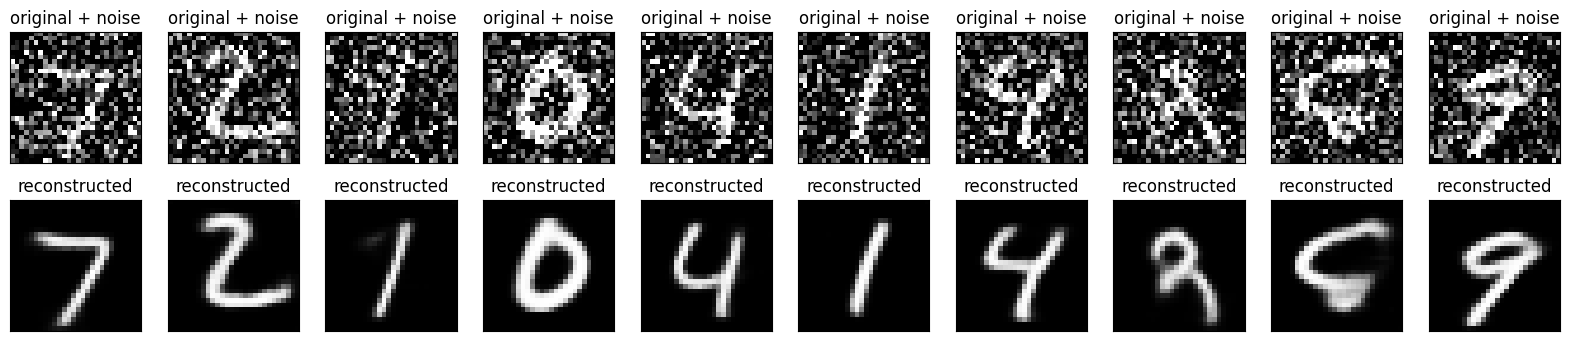

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # muestra las imagenes originales + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # muestra las imagenes reconstruidas
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

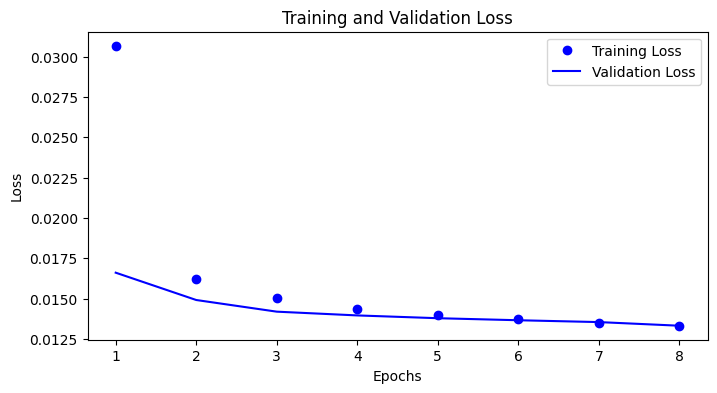

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)  # Generar una lista de épocas

# Visualización de la pérdida
plt.figure(figsize=(8, 4))
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

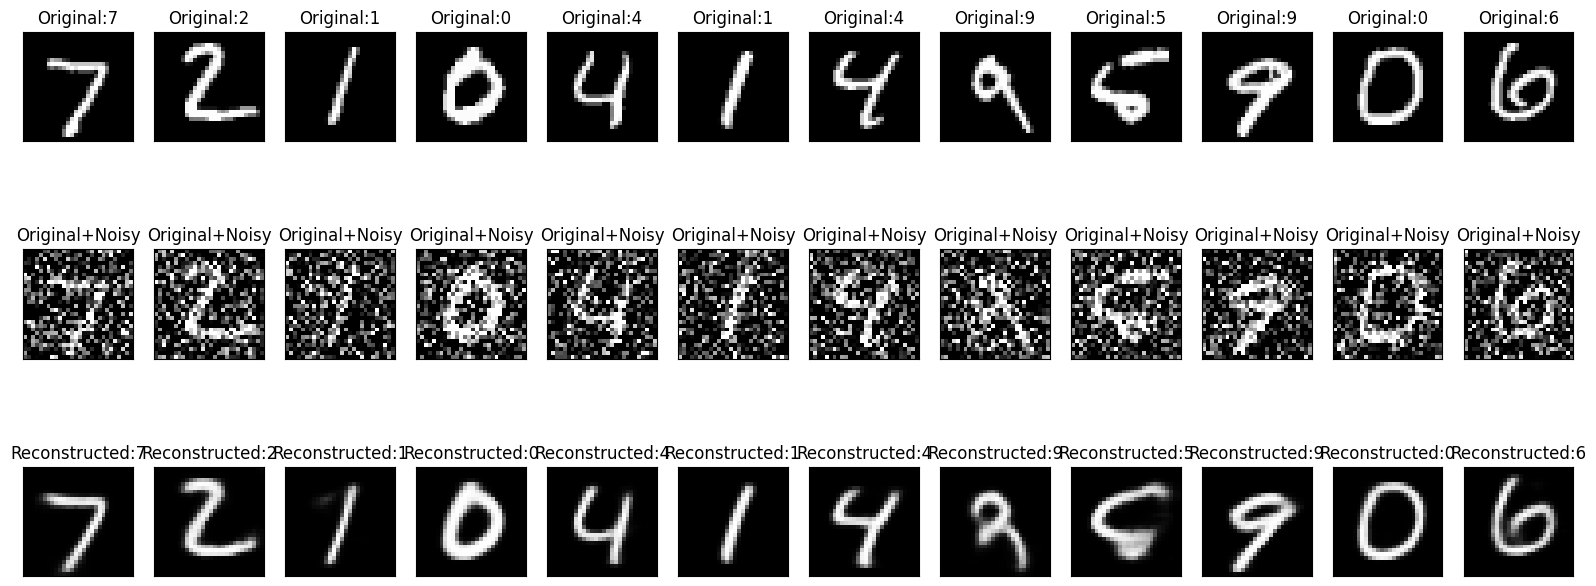

In [ ]:
n = 12  # Número de imágenes a mostrar
plt.figure(figsize=(20, 8))

# Mostramos todas las imágenes originales en una fila
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(image_size, image_size), cmap='gray')
    plt.title(f"Original:{y_test[i]}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Mostramos todas las imágenes con ruido en una fila
for i in range(n):
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].numpy().reshape(image_size, image_size), cmap='gray')
    plt.title(f"Original+Noisy")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Mostramos todas las imágenes reconstruidas en una fila
for i in range(n):
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(decoded_imgs[i].reshape(image_size, image_size), cmap='gray')
    plt.title(f"Reconstructed:{y_test[i]}")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


Finalmente, se muestran los resultados obtenidos al aplicar el Autocodificador sobre algunas de las imágenes con ruido del conjunto de test y como podemos ver en la anterior imagen, el resultado es bastante impresionante.

In [ ]:
# Reformatear decoded_imgs para que tenga la misma forma que x_test
decoded_imgs = np.reshape(decoded_imgs, (10000, 28, 28, 1))

# Calcular el Mean Squared Error (MSE)
mse = np.mean(np.square(x_test - decoded_imgs))
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.013316676020622253


## Uso de transfer learning?

El uso de Transfer Learning no es tan relevante como en otros escenarios, ya que MNIST es un conjunto de datos relativamente simple ya que solo consiste de imágenes en escala de grises de dígitos(del 0 al 9) escritos a mano, y solo le agregamos ruido, sin embargo la complejidad del problema no requiere características de alto nivel aprendidas en conjuntos de datos más grandes y complejos y Transfer Learning se beneficia más cuando se tiene acceso a grandes(muy grandes) conjuntos de datos, mientras que MNIST es un conjunto de datos pequeño(relativamente, porque en realidad tiene un tamaño considerable, necesario para el autoencoder) y muy específico.

Por último, el autoencoder esta hecho para eliminar ruido en imágenes MNIST y aprender representaciones compactas, la capacidad de este modelo no es tan grande como la de otras arquitecturas(más complejas) que se benefician más del transfer learning. No necesitamos aprovechar conocimientos previos sobre características visuales de estos números para poder eliminar el ruido de este.

## Uso de Data Augmentation

MNIST ya es un conjunto de datos relativamente grande(aunque no tan grande como para necesitar Transfer Learning) y completo para esta tarea que es muy específica. Sabemos que la necesidad de data augmentation es menor cuando ya se tiene acceso a una cantidad adecuada de datos.

Por otro lado las imágenes de dígitos en MNIST no son sensibles a transformaciones como rotaciones o giros. Estas transformaciones son más relevantes en conjuntos de datos con variabilidad en la orientación y la escala. En este caso las imágenes no requieren algún tipo de transformaciones para preservar su información, da igual.

Y por principios, es decir, como nuestro objetivo principal es eliminar el ruido de las imágenes, se busca que el modelo aprenda a reconstruir las imágenes originales, por lo que Data augmentation no es crítico para esta tarea, ya que no necesitaamos mayor diversidad en nuestros datos, está no nos importa al momento de eliminar el ruido de x imagen.

# Conclusiones

El autoencoder entrenado ha demostrado ser capaz de reducir el ruido de las imágenes con (grán) éxito. La capacidad del modelo para aprender una representación latente eficiente ha permitido la reconstrucción de imágenes originales a partir de versiones ruidosas, naturalmente ibamos a perder un poco de información, como en las imagenes de los 6's y 9's pero pese a eso también podemos observar que algunas partes(mal dibujadas) se mejoraron.

La arquitectura de nuestro autoencoder ha demostrado ser efectiva para aprender representaciones significativas de las imágenes ruidosas. La utilización de capas convolucionales y la reducción de la dimensión latente contribuyen a la capacidad del modelo para capturar patrones relevantes, esto se refleja en las imágenes visualmente y en nuestro MSE.

La adición de ruido a las imágenes de entrada como parte del proceso de entrenamiento ha demostrado ser una estrategia eficaz para mejorar la capacidad del autoencoder para generalizar y eliminar el ruido de nuevas imágenes.

La implementación de un callback (ReduceLROnPlateau) para ajustar dinámicamente la tasa de aprendizaje en función de la pérdida en el conjunto de validación es una práctica recomendada para mejorar la convergencia del modelo sin embargo en este caso no tuvimos una mejora muy significante ocupando esto. Creo que estamos intentando matar ganzos con bazokas. Y eso que no ocupamos tranfer learning y data augmentation. Tampoco empleamos algún regularizador, solo agregamos un pequeño Dropout de .2 que nos ayudo a prevenir la dependencia excesiva entre las unidades empleadas en el entrenamiento y mejora la robustez del modelo.

La principal ventaja de este método es que no tenemos que preocuparnos del tipo de filtro que debemos aplicar ya que que la red neuronal aprenderá sola cuál es el conjuno de filtros más óptimos a aplicar para obtener el resultado esperado.

Sin embargo, por otro lado, la principal desventaja de este método es que se necesita una gran cantidad de imágenes (más de 1000) para entrenar la red neuronal. Afortunadamente si contamos con un conjunto grande de imágenes para entrenar la red, en estos casos si podemos decir que es preferible utilizar autoencoders antes de cualquier otro método para reducir el ruido de las imágenes.

**Cabe recalcalcar que naturalmente Una reducción de la dimensionalidad implica que se pierde información por el camino, que estos datos ya no están completos.**

- Posibles Mejoras y Experimentación Adicional:
  - Pero si encuentran que la reconstrucción no es lo suficientemente precisa, se podría considerar aumentar o disminuir la complejidad del modelo ajustando el número de filtros en las capas de convolución o la dimensión del vector latente.
  -  Para futuras iteraciones, podemos explorar mejoras adicionales, como la experimentación con arquitecturas más complejas, la aplicación de técnicas de regularización o la exploración de otros conjuntos de datos o con otros tipos de ruido(que por lo que investigue, existen varios).

### Referencias

- **[0]** Material visto y proporcionado en clase(en particular lo visto en la clase 21).
- **[1]** Sosa-Costa, A. (2019, octubre 1). Reducción de ruido en imágenes utilizando Autocodificadores. Cursos de Programación de 0 a Experto Garantizados. Recuperado el 7 de diciembre de 2023, de: https://unipython.com/reduccion-de-ruido-en-imagenes-utilizando-autocodificadores/

- **[2]** Jesús. (2019, enero 19). Autoencoders. DataSmarts. Recuperado el 9 de diciembre de 2023, de: https://www.datasmarts.net/autoencoders/

- **[3]** Rowel Atienza, 2020, *Advanced Deep Learning with TensorFlow 2 and Keras* (Second Edition), Packt Publishing Ltd. Recuperado el 10 de diciembre de 2023, de:  https://www.hlevkin.com/hlevkin/45MachineDeepLearning/Keras/Advanced%20Deep%20Learning%20with%20TensorFlow%202%20and%20Keras.pdf

- **[4]** Rodríguez Ferrero, Ignacio, *Uso de autoencoders en la compresión de imágenes*(Trabajo Fin De Grado, UNIVERSITAT POLITÈCNICA DE VALÈNCIA) Recuperado el 10 de diciembre de 2023, de: https://riunet.upv.es/bitstream/handle/10251/185803/Rodriguez%20-%20Uso%20de%20autoencoders%20en%20la%20compresion%20de%20imagenes.pdf?sequence=1